In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp

from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

In [2]:
adata_full = ad.read_h5ad(FILE := "out/results/GAT_2024-05-23-16-24-07_results.h5ad")

In [3]:
adata = adata_full

In [162]:
# adata = adata_full[adata_full.obs["Supertype"] == "Astrocytes"]
# adata = adata_full[adata_full.obs["Supertype"] == "Oligodendrocytes"]
# adata = adata_full[adata_full.obs["Supertype"].isin(["Excitatory_neurons_set1, Excitatory_neurons_set2", "Excitatory_neurons_set3"])]
# adata = adata_full[adata_full.obs["Supertype"] == "Inhibitory_neurons"]
# adata = adata_full[adata_full.obs["Supertype"] == "OPCs"]
# adata = adata_full[adata_full.obs["Supertype"] == "Immune_cells"]
adata = adata_full[adata_full.obs["Supertype"] == "Vasculature_cells"]
adata

View of AnnData object with n_obs × n_vars = 16909 × 1000
    obs: 'projid', 'Supertype', 'Donor ID', 'cell_type_high_resolution', 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl'

In [163]:
adata.obs["cell_type_high_resolution"].value_counts()

cell_type_high_resolution
End           6156
Per           5061
Fib FLRT2     3497
SMC           1546
Fib SLC4A4     649
Name: count, dtype: int64

In [164]:
# adata = adata[adata.obs["cell_type_high_resolution"] == "Mic P2RY12"]

In [165]:
adata = adata[adata.obs["Label"] != "Other"]  # Drop intermediate donors for this part

In [166]:
# adata = adata[adata.obs["test_donor_f4"]]  # Only use the test donors for this part

In [167]:
FOLD = 0

In [168]:
# Find which donors were correctly classified in fold
DONORS = adata.obs["Donor ID"].unique()

predictions = adata.uns[f"y_pred_graph_f{FOLD}"]  # Dictionary with all donors, values are np arrays of length 2 [p(CT), p(AD)]

correct_donors = []
donor_accuracies = {}  # {donor: (pred_y, pred_label, true_y, true_label)}

for donor in DONORS:
    pred_y = predictions[f"{donor}"][0, 1]  # p(AD)
    if pred_y < 0.5:
        pred_label = "CT"
    else:
        pred_label = "AD"

    true_label = adata.obs["Label"][adata.obs["Donor ID"] == donor].values[0]
    true_y = 1 if true_label == "AD" else 0

    if pred_label == true_label:
        correct_donors.append(donor)

    donor_accuracies[donor] = (pred_y, pred_label, true_y, true_label)

In [169]:
# adata = adata[adata.obs["Donor ID"].isin(correct_donors)]
adata

View of AnnData object with n_obs × n_vars = 7499 × 1000
    obs: 'projid', 'Supertype', 'Donor ID', 'cell_type_high_resolution', 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl',

<Axes: xlabel='PCA1', ylabel='Count'>

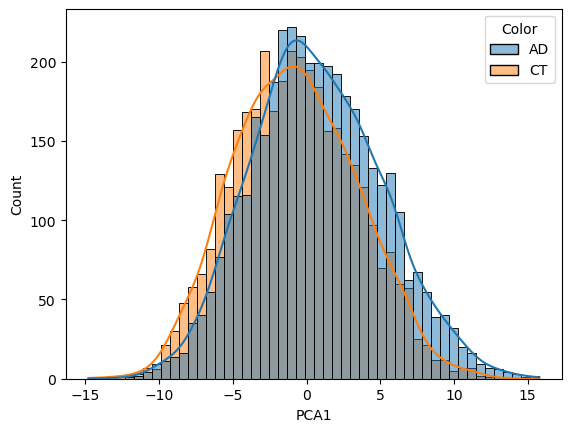

In [170]:
pca = PCA(n_components=5)
x_pca = pca.fit_transform(adata.obsm[f"h_2_f{FOLD}"].toarray())
# x_pca = adata.obs["y"].to_numpy().reshape(-1, 1)

df = pd.DataFrame({
    "PCA1": x_pca[:, 0],
    # "PCA2": x_pca[:, 1],
    "Color": adata.obs["Label"].values
})
sns.histplot(df, x="PCA1", hue="Color", kde=True)

In [171]:
gene_vars = adata.X.toarray().var(axis=0)

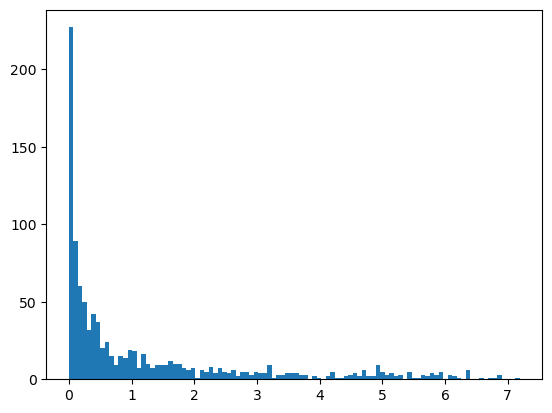

In [172]:
plt.hist(gene_vars, bins=100)
plt.show()

100%|██████████| 1000/1000 [00:03<00:00, 260.45it/s]


Skipped 13 genes due to zero variance:
['LINC01972', 'CSN1S1', 'TRIM31', 'DCSTAMP', 'GLT6D1', 'CD3D', 'OR6C2', 'LINC02424', 'IGHM', 'LINC00929', 'AC243654.1', 'OTOP2', 'IGLC2']


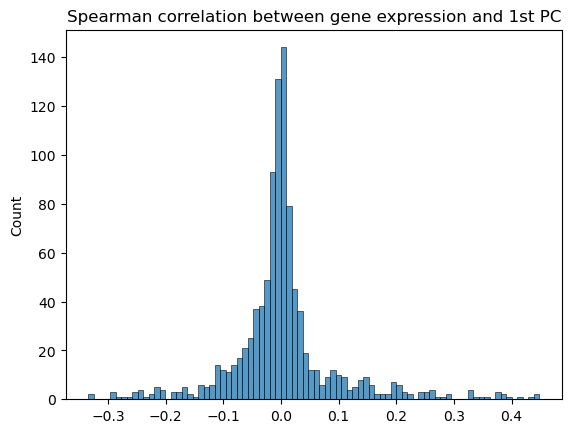

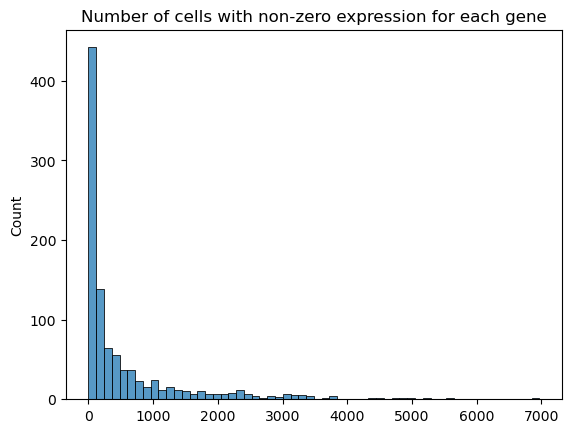

In [173]:
# We use spearman correlation to find genes that are correlated with the first PCA component.
# This is better than using Pearson correlation since the gene expression data is not normally distributed, and highly sparse.

spearman_corrs = []
skipped_genes = []
gene_cells = []

for i, gene in enumerate(tqdm(adata.var_names)):
    gene_expr = adata.X[:, i].toarray().flatten()
    gene_cells.append(gene_expr.nonzero()[0].shape[0])

    # Skip genes with zero variance (actually, they just have all 0's)
    if np.var(gene_expr) == 0:
        skipped_genes.append(gene)
        spearman_corrs.append(0)
        continue

    corr, _ = spearmanr(gene_expr, x_pca[:, 0])
    spearman_corrs.append(corr)

print(f"Skipped {len(skipped_genes)} genes due to zero variance:")
print(skipped_genes)

spearman_corrs = pd.Series(spearman_corrs, index=adata.var_names)

ax, fig = plt.subplots()
sns.histplot(spearman_corrs)
plt.title("Spearman correlation between gene expression and 1st PC")
plt.show()

ax, fig = plt.subplots()
sns.histplot(gene_cells)
plt.title("Number of cells with non-zero expression for each gene")
plt.show()

In [174]:
# Rank the genes by their spearman correlation (absolute value)
ranking = pd.Series(spearman_corrs, index=adata.var_names)
# ranking = ranking[np.array(gene_cells) > adata.n_obs * 0.1]  # Only keep genes that are expressed in at least 10% of cells
ranking = ranking[ranking.abs().sort_values(ascending=False).index]
ranking.head(20)

FLT1       0.448057
CLDN5      0.442162
MT2A       0.431253
ERG        0.418052
CEMIP2     0.392829
MT1M       0.385571
ADGRL4     0.384869
ATP10A     0.379013
ABCB1      0.377096
ANO2       0.373321
BTNL9      0.354462
TMSB10     0.346544
MT1E       0.339008
PRKG1     -0.333885
FAM107A    0.330710
CGNL1      0.329708
MT1X       0.328264
COLEC12   -0.326318
ST8SIA6    0.325464
ZFHX3     -0.294922
dtype: float64

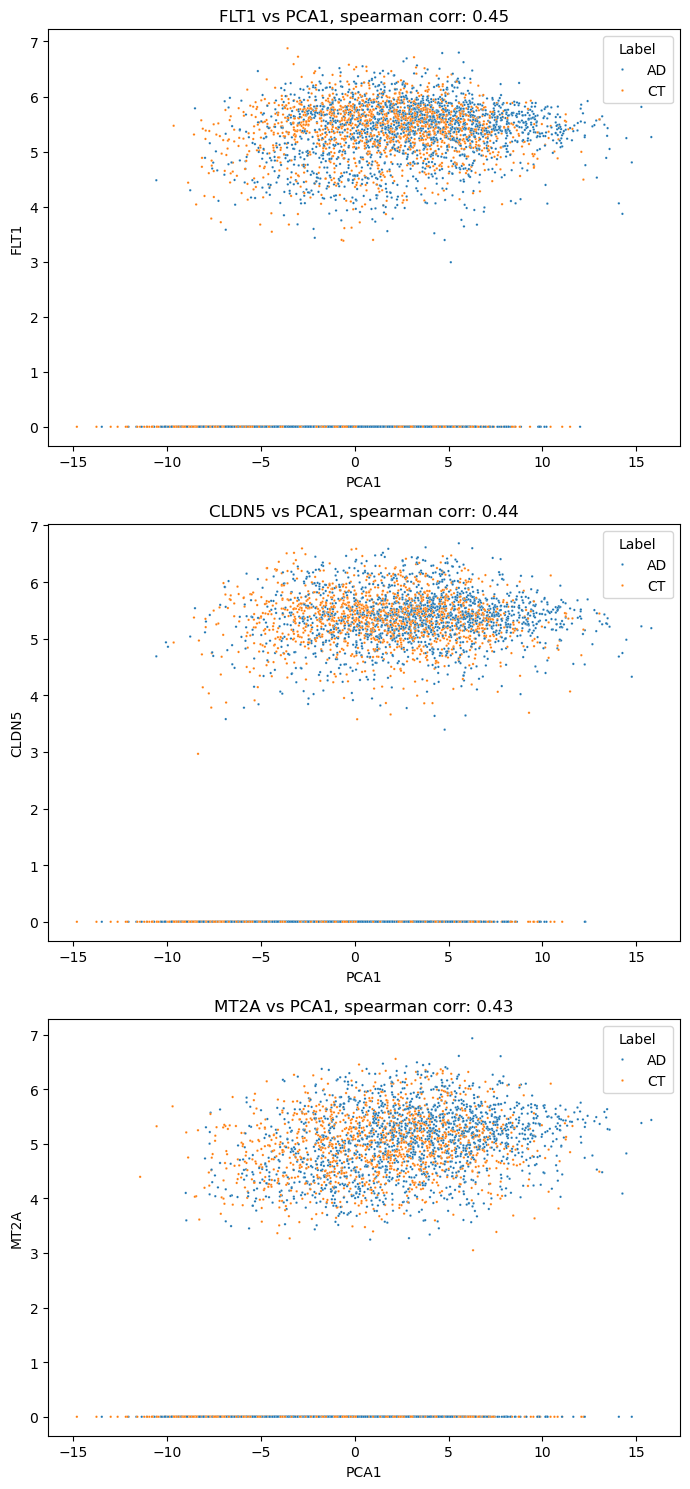

In [175]:
# Color a scatterplot of the first PC with the expression of the top could of genes

n_genes_plot = 3

fig, axs = plt.subplots(nrows=n_genes_plot, ncols=1, figsize=(7, 5 * n_genes_plot))

for i, gene in enumerate(ranking.head(n_genes_plot).index):
    ax = axs[i]
    sns.scatterplot(
        x = x_pca[:, 0],
        y = adata[:, adata.var_names == gene].X.toarray().flatten(),
        hue = adata.obs["Label"],
        ax = ax,
        s = 3,
    )

    ax.set_title(f"{gene} vs PCA1, spearman corr: {ranking[gene]:.2f}")
    ax.set_xlabel("PCA1")
    ax.set_ylabel(gene)

plt.tight_layout()
plt.show()

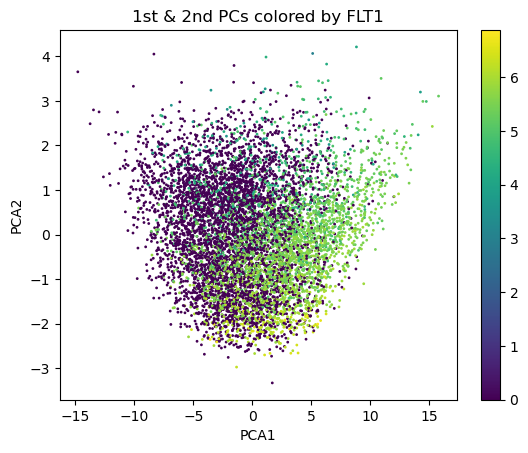

In [176]:
# Color PCA according to top gene

df = pd.DataFrame({
    "PCA1": x_pca[:, 0],
    "PCA2": x_pca[:, 1],
    "Color": adata[:, adata.var_names == ranking.index[0]].X.toarray().flatten(),
})

plt.scatter(
    df["PCA1"],
    df["PCA2"],
    c=df["Color"],
    cmap="viridis",
    s=1,
)
plt.colorbar()
plt.title(f"1st & 2nd PCs colored by {ranking.index[0]}")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Gene Set Enrichment Analysis

In [177]:
raw_response = gp.prerank(
    rnk=ranking, 
    gene_sets=[
        # Disease phenotype related:
        # "DisGeNET",
        # "OMIM_Disease",
        # "OMIM_Expanded",
        # "UK_Biobank_GWAS_v1",
        # "Jensen_DISEASES"
        # "GWAS_Catalog_2023",

        # Brain-specific:
        # "PanglaoDB_Augmented_2021",
        # "Aging_Perturbations_from_GEO_down",
        # "Aging_Perturbations_from_GEO_up",
        # "Allen_Brain_Atlas_10x_scRNA_2021",
        # "Allen_Brain_Atlas_down",
        # "Allen_Brain_Atlas_up",
        "GO_Biological_Process_2023",
        # "GO_Cellular_Component_2023",
        # "GO_Molecular_Function_2023"
        # "GTEx_Aging_Signatures_2021",
        # "HDSigDB_Human_2021",
        "KEGG_2021_Human",

        # "Azimuth_Cell_Types_2021",
        # "WikiPathways_2024_Human",
    ],
    # outdir="out/results/gsea/Ast_GO-2023", 
    min_size=1,  # (default = 15)
    max_size=10000,  # (default = 500)
    # permutation_num=1000,
    verbose=True,
)

2024-11-12 17:34:26,361 [WARNING] Duplicated values found in preranked stats: 1.20% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-11-12 17:34:26,361 [INFO] Parsing data files for GSEA.............................
2024-11-12 17:34:26,361 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-12 17:34:26,401 [INFO] Enrichr library gene sets already downloaded in: C:\Users\timo\.cache/gseapy, use local file
2024-11-12 17:34:26,432 [INFO] 2724 gene_sets have been filtered out when max_size=10000 and min_size=1
2024-11-12 17:34:26,432 [INFO] 3003 gene_sets used for further statistical testing.....
2024-11-12 17:34:26,432 [INFO] Start to run GSEA...Might take a while..................
2024-11-12 17:34:29,690 [INFO] Congratulations. GSEApy runs successfully................



In [178]:
res = raw_response.res2d.copy()

In [179]:
alz_terms = res[res["Term"].str.contains("Alz")]
alz_terms.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
721,prerank,KEGG_2021_Human__Alzheimer disease,0.595617,1.237513,0.203901,0.663147,1.0,6/15,16.50%,BACE2;GAPDH;TUBA1B;NOX4;CHRM5;RYR3


In [180]:
# Show only significant results, sorted by absolute NES
res_sig = res[res["FDR q-val"] < 0.05].copy()
res_sig.insert(0, "abs_NES", res_sig["NES"].abs())
res_sig.sort_values("NES", ascending=False, inplace=True)
n_sig = res_sig.shape[0]
print(f"Found {n_sig} significant terms")
res_sig.head(20).drop(columns=["abs_NES", "Name"])

Found 0 significant terms


,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


In [181]:
# write to file
celltype = adata.obs["Supertype"].values[0]
res_out = res_sig.copy()
res_out["Celltype"] = celltype
res_out.drop(columns=["Name", "abs_NES"])
res_out.to_csv(f"out/results/gsea/{celltype}.csv")

In [182]:
if n_sig > 0:
    top_terms = min(50, n_sig)

    gp.plot.dotplot(
        df = res,
        # column = "NOM p-val",
        column = "FDR q-val",  # Should use this one (corrected p-value)
        # column = "NES",
        top_term=top_terms,
        figsize=(8, 4),
        size=7,
        cutoff=0.05,
    )

## GSEA without pre-ranking

The above method doesn't show any enrichment for cell types other than Astrocytes.

Instead, we just pick the top k genes, and use the rest of the genes as background.

In [183]:
top_k = 50
res = gp.enrichr(
    gene_list=ranking[:top_k].index.tolist(),
    background=adata.var_names,
    # description="asdf",
    gene_sets=[
        "KEGG_2021_Human",
        "GO_Biological_Process_2023",
    ],
    cutoff=0.05,
    # format="png",
    # figsize=(8, 6),
).results
res_sig = res[res["Adjusted P-value"] < 0.05].copy()
res_sig.head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Mineral absorption,0.000013,0.001397,0,0,35.074074,395.104459,MT2A;MT1M;MT1X;ATP1A2;MT1E
109,GO_Biological_Process_2023,Cellular Response To Zinc Ion (GO:0071294),0.000077,0.019296,0,0,41.217391,390.208404,MT2A;MT1M;MT1X;MT1E
110,GO_Biological_Process_2023,Cellular Response To Copper Ion (GO:0071280),0.000174,0.019296,0,0,27.449275,237.638392,MT2A;MT1M;MT1X;MT1E
111,GO_Biological_Process_2023,Response To Copper Ion (GO:0046688),0.000174,0.019296,0,0,27.449275,237.638392,MT2A;MT1M;MT1X;MT1E
112,GO_Biological_Process_2023,Response To Zinc Ion (GO:0010043),0.000174,0.019296,0,0,27.449275,237.638392,MT2A;MT1M;MT1X;MT1E


In [184]:
res_sig.to_csv(f"out/results/gsea_top{top_k}/{celltype}.csv")

c:\Users\timo\Repositories\geneGNN\.pixi\envs\default\Lib\site-packages\gseapy\plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
c:\Users\timo\Repositories\geneGNN\.pixi\envs\default\Lib\site-packages\gseapy\plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


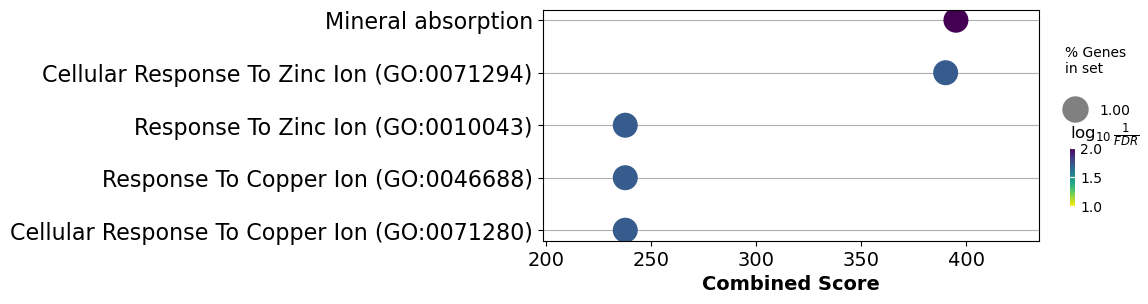

In [188]:
if res_sig.shape[0] > 0:
    gp.plot.dotplot(
        df = res,
        column = "Adjusted P-value",
        top_term=top_k,
        figsize=(8, 3),
        size=3,
        cutoff=0.05,
    )